In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
import random
import hypertools as hyp
import tensorflow as tf
%matplotlib inline

/Users/junyang/anaconda2/envs/p3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data Preprocessing

In [2]:
max_x = 1128
max_y = 600
month_dict = {
    'JAN':'01',
    'FEB':'02',
    'MAR':'03',
    'APR':'04',
    'OCT':'10',
    'NOV':'11',
    'DEC':'12'
}

## 1. DUKE shotlogs

In [3]:
def to_seconds(time, period):
    return int(time.split(':')[0])*60 + int(time.split(':')[1]) + 20*60*(period-1)

def have_missing_value(row):
    for item in row:
        if item == '':
            return True
    return False

def relative_court_position(x,y):
    if x > max_x / 2:
        x = max_x - x
        y = max_y - y
    return x,y

def datetime(date):
    day,month,year = date.split()[0].split('-')
    return '20'+year+'-'+month_dict[month]+'-'+day

def random_outcome():
    random.seed(10)
    p = random.uniform(0,1)
    if p > 0.5:
        return 1
    else:
        return 0

In [4]:
# a dict stores {key: game, value: [shot1, shot2,...,]}
# per game shotlogs, not per person
duke_shotlogs = defaultdict(list)
x_max = 0
y_max = 0
with open('duke_shotlog.csv','r') as f:
    csv_reader = csv.reader(f, delimiter=';')
    line_cnt = 0
    for row in csv_reader:
        if have_missing_value(row):
            continue
        if line_cnt == 0: ## skip the first attribute-line
            pass
        else:
            game_id = 'duke-'+row[10]+'-'+row[11]+'-'+row[12] #year-month-date
            shot_pos_time = (to_seconds(row[14], int(row[3])), int(row[7]), int(row[8]))
            if int(row[7]) > x_max:
                x_max = int(row[7])
            if int(row[8]) > y_max:
                y_max = int(row[8])
            duke_shotlogs[game_id].append(shot_pos_time)
        line_cnt += 1
print('{} shot log records in total'.format(line_cnt))
for game in duke_shotlogs.keys():
    duke_shotlogs[game] = sorted(duke_shotlogs[game], key = lambda x: x[0])
# print(len(duke_shotlogs['duke-2016-3-10']),duke_shotlogs['duke-2016-3-10'])


988 shot log records in total


In [5]:
new_duke_shotlogs = defaultdict(list)
print(x_max,y_max)
for idx,game in enumerate(duke_shotlogs.keys()):
    if len(duke_shotlogs[game]) < 100:
        continue
    else:
        for item in duke_shotlogs[game]:
            if item[1] > x_max / 2:
                x = x_max - item[1]
                y = y_max - item[2]
            else:
                x = item[1]
                y = item[2]
            new_duke_shotlogs[game].append([item[0], x, y])

91 49


128
9


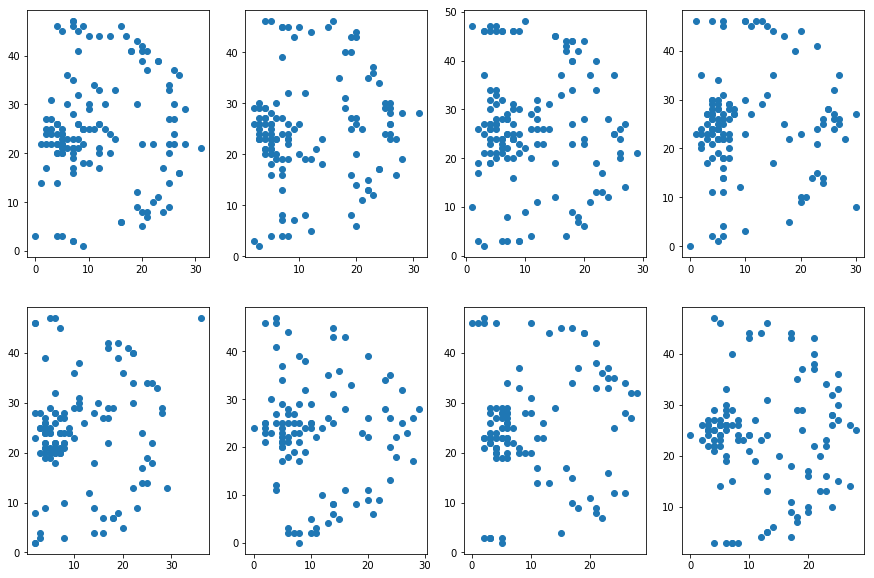

In [6]:
print(len(duke_shotlogs['duke-2016-3-9']))
print(len(duke_shotlogs))
plt.figure(figsize=(15,10))
for idx,game in enumerate(new_duke_shotlogs.keys()):
    plt.subplot(2,4,idx+1)
    x= []
    y= []
    for item in new_duke_shotlogs[game]:
        x.append(item[1])
        y.append(item[2])
    plt.scatter(x,y)

## 2. All NCAA team shotlogs

In [7]:
# event_coord_x	FLOAT	NULLABLE	
# The location of the play in number of inches from the "left" baseline, max 1128
# event_coord_y	FLOAT	NULLABLE	
# The location of the play in inches from the "top" sideline, max 600

ncaa_shotlogs = defaultdict(list)
ncaa_shotlogs_raw = defaultdict(list)
all_teams = {}
with open('ncaa-shotlog.csv','r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_cnt = 0
    for row in csv_reader:
        if have_missing_value(row):
            continue
        if line_cnt == 0:
            line_cnt += 1
        else:
            if row[2] not in all_teams:
                all_teams[row[2]] = len(all_teams)
            game_id = row[2]+'-'+row[1].split(' ')[0]
            x,y = relative_court_position(int(row[9]), int(row[10]))
            shot_pos_time = (int(row[5]),x,y)
            shot_pos_time_raw = (int(row[5]), int(row[9]), int(row[10]))
            ncaa_shotlogs[game_id].append(shot_pos_time)
            ncaa_shotlogs_raw[game_id].append(shot_pos_time_raw)
        line_cnt += 1
print('{} shot log records in total'.format(line_cnt))
for game in ncaa_shotlogs.keys():
    ncaa_shotlogs[game] = sorted(ncaa_shotlogs[game], key = lambda x: x[0])

1271955 shot log records in total


In [8]:
ncaa_shotlogs_team = defaultdict(list)
for game in ncaa_shotlogs:
    ncaa_shotlogs_team[game.split('-')[0]].append(ncaa_shotlogs[game])


In [9]:
for game in ncaa_shotlogs.keys():
    print(len(ncaa_shotlogs[game]))
    print(ncaa_shotlogs[game])
    break
print(np.mean([len(ncaa_shotlogs[game]) for game in ncaa_shotlogs]))

115
[(23, 93, 180), (72, 300, 313), (88, 289, 204), (140, 344, 312), (145, 87, 319), (160, 314, 471), (165, 150, 299), (209, 287, 283), (227, 90, 573), (269, 81, 313), (287, 166, 314), (310, 71, 328), (316, 49, 585), (343, 80, 288), (371, 83, 271), (392, 194, 235), (406, 70, 570), (433, 77, 280), (453, 74, 277), (458, 255, 499), (500, 122, 306), (507, 73, 572), (556, 310, 168), (571, 76, 314), (581, 109, 286), (599, 83, 313), (630, 80, 315), (645, 109, 234), (657, 157, 493), (684, 339, 331), (722, 63, 290), (728, 74, 286), (802, 129, 319), (828, 86, 340), (844, 78, 319), (853, 248, 97), (893, 73, 321), (893, 84, 568), (933, 81, 288), (950, 83, 318), (986, 267, 108), (1030, 269, 119), (1083, 301, 300), (1119, 109, 296), (1121, 291, 282), (1155, 81, 245), (1169, 90, 321), (1190, 282, 254), (1209, 70, 336), (1213, 84, 288), (1229, 71, 286), (1268, 63, 388), (1271, 181, 279), (1296, 144, 245), (1315, 60, 492), (1322, 78, 284), (1360, 78, 318), (1362, 342, 309), (1365, 281, 286), (1383, 88,

In [10]:
number_of_games = [len(ncaa_shotlogs_team[team]) for team in ncaa_shotlogs_team.keys()]
plt.bar(range(231), number_of_games)
print('max: {}, min: {}, avg: {}'.format(np.max(number_of_games), np.min(number_of_games), np.mean(number_of_games)))

max: 478, min: 1, avg: 84.3896103896104


In [11]:
ncaa_shotlogs_team_selected = {k:v for k,v in ncaa_shotlogs_team.items() if len(v) > 100}
number_of_games = [len(ncaa_shotlogs_team_selected[team]) for team in ncaa_shotlogs_team_selected]
plt.bar(range(len(ncaa_shotlogs_team_selected)), number_of_games)
print(len(ncaa_shotlogs_team_selected))
print('max: {}, min: {}, avg: {}'.format(np.max(number_of_games), np.min(number_of_games), np.mean(number_of_games)))

85
max: 478, min: 106, avg: 181.9294117647059


In [12]:
for team in ncaa_shotlogs_team_selected.keys():
    print(ncaa_shotlogs_team_selected[team][0])
    break
print(np.mean([len(game) for team in ncaa_shotlogs_team_selected for game in ncaa_shotlogs_team_selected[team]]))

[(23, 93, 180), (72, 300, 313), (88, 289, 204), (140, 344, 312), (145, 87, 319), (160, 314, 471), (165, 150, 299), (209, 287, 283), (227, 90, 573), (269, 81, 313), (287, 166, 314), (310, 71, 328), (316, 49, 585), (343, 80, 288), (371, 83, 271), (392, 194, 235), (406, 70, 570), (433, 77, 280), (453, 74, 277), (458, 255, 499), (500, 122, 306), (507, 73, 572), (556, 310, 168), (571, 76, 314), (581, 109, 286), (599, 83, 313), (630, 80, 315), (645, 109, 234), (657, 157, 493), (684, 339, 331), (722, 63, 290), (728, 74, 286), (802, 129, 319), (828, 86, 340), (844, 78, 319), (853, 248, 97), (893, 73, 321), (893, 84, 568), (933, 81, 288), (950, 83, 318), (986, 267, 108), (1030, 269, 119), (1083, 301, 300), (1119, 109, 296), (1121, 291, 282), (1155, 81, 245), (1169, 90, 321), (1190, 282, 254), (1209, 70, 336), (1213, 84, 288), (1229, 71, 286), (1268, 63, 388), (1271, 181, 279), (1296, 144, 245), (1315, 60, 492), (1322, 78, 284), (1360, 78, 318), (1362, 342, 309), (1365, 281, 286), (1383, 88, 300

In [13]:
selected_team_index = {}
idx = 0
for team in ncaa_shotlogs_team_selected:
    selected_team_index[team] = idx
    idx += 1

In [42]:
index_to_team = {}
for team in ncaa_shotlogs_team_selected:
    index_to_team[selected_team_index[team]] = team

In [15]:
for team in ncaa_shotlogs_team_selected:
    print(team, selected_team_index[team])

Bears 0
Eagles 1
Tar Heels 2
Cowboys 3
Rams 4
Spartans 5
Tigers 6
Gamecocks 7
Golden Eagles 8
Wildcats 9
Huskies 10
Aztecs 11
Panthers 12
Owls 13
Lions 14
Mustangs 15
Mountaineers 16
Aggies 17
Cougars 18
Broncos 19
Bulldogs 20
Colonials 21
Trojans 22
Knights 23
Hawks 24
Gators 25
Wolfpack 26
Blue Devils 27
Nittany Lions 28
Boilermakers 29
Red Storm 30
Billikens 31
Gaels 32
Orange 33
Horned Frogs 34
Longhorns 35
Red Raiders 36
Terrapins 37
Wolverines 38
Cornhuskers 39
Sooners 40
Rebels 41
Cardinal 42
Cavaliers 43
Bluejays 44
Bearcats 45
Golden Gophers 46
Volunteers 47
Pirates 48
Hoosiers 49
Scarlet Knights 50
Razorbacks 51
Buffaloes 52
Fighting Illini 53
Bulls 54
Hoyas 55
Hawkeyes 56
Lobos 57
Commodores 58
Badgers 59
Musketeers 60
Cardinals 61
Golden Bears 62
Cyclones 63
Hurricanes 64
Fighting Irish 65
Buckeyes 66
Friars 67
Beavers 68
Seminoles 69
Jayhawks 70
Demon Deacons 71
Ducks 72
Bruins 73
Flyers 74
Hokies 75
Wolf Pack 76
Blue Demons 77
Utes 78
Golden Hurricane 79
Shockers 80
Sun D

In [16]:
def shotlog_visualization(team_shotlogs, num):
    for idx,shotlogs in enumerate(random.sample(team_shotlogs, num)):
        plt.subplot(1,num,idx+1)
        x= []
        y= []
        for item in shotlogs:
            x.append(item[1])
            y.append(item[2])
        plt.scatter(x,y)
        plt.xlim([0,max_x/2])
        plt.ylim([0,max_y])

Owls
Tigers
Fighting Illini


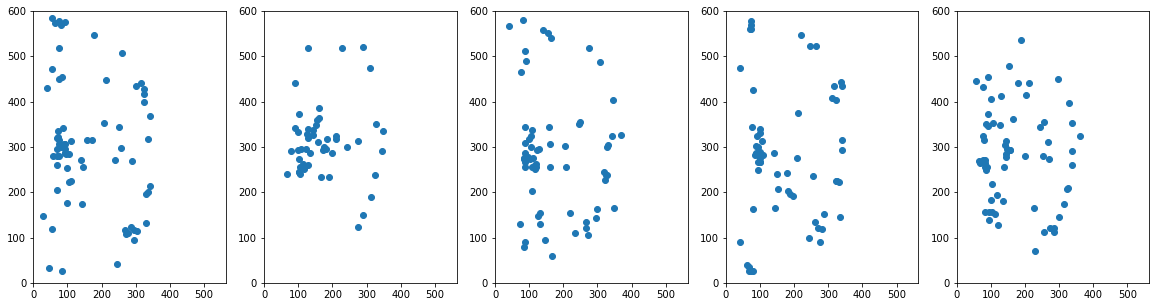

In [17]:
teams = random.sample(ncaa_shotlogs_team_selected.keys(), 3)
for team in teams:
    plt.figure(figsize=(20,5))
    print(team)
    shotlog_visualization(ncaa_shotlogs_team_selected[team],5)

In [18]:
import random
print(random.sample(ncaa_shotlogs.keys(), 10))

['Aces-2015-12-12', 'Golden Gophers-2013-11-25', 'Wildcats-2017-03-25', 'Cardinal-2015-01-05', 'Cyclones-2016-12-18', 'Bearcats-2016-11-16', 'Yellow Jackets-2018-01-13', 'Musketeers-2017-12-28', 'Sooners-2014-11-23', 'Cyclones-2015-01-27']


In [19]:
print(len(ncaa_shotlogs['Wildcats-2016-01-13']), ncaa_shotlogs['Wildcats-2016-01-13'])
print(len(ncaa_shotlogs['Mavericks-2016-12-23']), ncaa_shotlogs['Mavericks-2016-12-23'])

217 [(23, 275, 108), (23, 97, 334), (40, 148, 280), (43, 329, 393), (63, 78, 343), (64, 347, 276), (65, 81, 331), (66, 260, 434), (80, 150, 296), (91, 81, 249), (99, 87, 289), (103, 330, 137), (110, 297, 102), (116, 84, 264), (134, 285, 94), (135, 80, 286), (140, 232, 273), (156, 84, 192), (157, 223, 547), (163, 84, 292), (167, 143, 372), (180, 112, 248), (197, 95, 315), (207, 112, 271), (208, 302, 98), (227, 309, 143), (238, 146, 570), (244, 285, 105), (273, 295, 127), (298, 266, 280), (300, 218, 74), (310, 95, 346), (323, 195, 389), (337, 345, 205), (339, 88, 292), (343, 122, 248), (353, 261, 476), (367, 156, 332), (367, 63, 204), (384, 233, 310), (388, 117, 33), (402, 198, 377), (418, 330, 294), (438, 100, 331), (444, 216, 242), (465, 138, 35), (470, 88, 560), (480, 206, 340), (492, 282, 461), (497, 93, 310), (521, 201, 322), (524, 295, 139), (531, 226, 340), (564, 228, 539), (570, 152, 52), (587, 110, 339), (602, 212, 272), (604, 89, 325), (621, 50, 550), (626, 292, 111), (632, 84,

In [30]:
plt.subplot(1,2,1)
x = []
y = []
for item in ncaa_shotlogs['Buffaloes-2016-12-08']:
    x.append(item[1])
    y.append(item[2])
plt.scatter(x,y)
plt.xlim([0,max_x])
plt.ylim([0,max_y])
plt.subplot(1,2,2)
x = []
y = []
for item in ncaa_shotlogs_raw['Buffaloes-2016-12-08']:
    x.append(item[1])
    y.append(item[2])
plt.scatter(x,y)
plt.xlim([0,max_x])
plt.ylim([0,max_y])
print(all_label['Buffaloes-2016-12-08'])

1


In [31]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
x = []
y = []
for item in ncaa_shotlogs_raw['Wildcats-2016-01-13']:
    x.append(item[1])
    y.append(item[2])
plt.scatter(x,y)
plt.xlim([0,max_x])
plt.ylim([0,max_y])
plt.title('(a) shotlogs before transformation')
plt.subplot(1,2,2)
x = []
y = []
for item in ncaa_shotlogs['Wildcats-2016-01-13']:
    x.append(item[1])
    y.append(item[2])
plt.scatter(x,y)
plt.xlim([0,max_x])
plt.ylim([0,max_y])
plt.title('(b) shotlogs after transformation')
print(clean_label['Wildcats-2016-01-13'])

0


## 3. NCAA game win/lose outcomes

In [22]:
ncaa_game_outcomes = {}
with open('ncaa-game-outcome.csv','r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_cnt = 0
    for row in csv_reader:
        if line_cnt == 0:
            pass
        else:
            team = row[2]
            outcome = row[3]
            scheduled_date = datetime(row[1])
            if outcome == 'false':
                outcome = 0
            else:
                outcome = 1
            ncaa_game_outcomes[team+'-'+scheduled_date] = outcome
        line_cnt += 1
print('{} game records in total'.format(line_cnt))

102888 game records in total


In [23]:
missing_cnt = 0
for key in ncaa_shotlogs.keys():
    if key not in ncaa_game_outcomes:
        missing_cnt += 1
print('{} game outcomes out of {} are missing'.format(missing_cnt, len(ncaa_shotlogs)))

9989 game outcomes out of 19494 are missing


## 4. Prepare training data

In [24]:
clean_data = defaultdict(list)
clean_label = {}
all_label = {}

for key in ncaa_shotlogs.keys():
    if key in ncaa_game_outcomes:
        clean_data[key] = ncaa_shotlogs[key]
        clean_label[key] = ncaa_game_outcomes[key]
        all_label[key] = ncaa_game_outcomes[key]
    else:
        all_label[key] = random_outcome()

print('there are {} game records with win/lose outcomes'.format(len(clean_label)))
print('there are {} game records in total,missing win/lose outcomes are imputed randomly with equal probability'\
      .format(len(all_label)))

there are 9505 game records with win/lose outcomes
there are 19494 game records in total,missing win/lose outcomes are imputed randomly with equal probability


## 4.1 shotlog matrix 

In [25]:
ncaa_shotlogs_data = []
ncaa_shotlogs_label = []
ncaa_team_shotlogs = []

for key in ncaa_shotlogs:
    m = np.zeros((40*60 + 1, 2))
    n = np.zeros((len(selected_team_index), 1))
    team = key.split('-')[0]
    if team not in selected_team_index:
        continue
    n[selected_team_index[team]][0] = 1
    for loc in ncaa_shotlogs[key]:
        if loc[0] < 0 or loc[0] > 40*60:
            continue
        m[loc[0]][0] = loc[1]
        m[loc[0]][1] = loc[2]
        
#     ncaa_shotlogs_data.append(m)
#     ncaa_shotlogs_label.append(clean_label[key])
    ncaa_team_shotlogs.append((m,n))

In [26]:
def training_data(team_shotlogs):
    data = team_shotlogs
    feature = [item[0] for item in data]
    feature = np.array(feature).reshape(len(feature), 2401*2)
    label = [item[1] for item in data]
    label = np.array(label).reshape(len(label), len(selected_team_index))
    return feature, label

def validation_data(team_shotlogs):
    data = team_shotlogs[:1000]
    feature = [item[0] for item in data]
    feature = np.array(feature).reshape(len(feature), 2401*2)
    label = [item[1] for item in data]
    label = np.array(label).reshape(len(label), len(selected_team_index))
    return feature, label

def test_data(team_shotlogs):
    data = random.sample(team_shotlogs, 1000)
    feature = [item[0] for item in data]
    feature = np.array(feature).reshape(len(feature), 2401*2)
    label = [item[1] for item in data]
    label = np.array(label).reshape(len(label), len(selected_team_index))
    return feature, label

def next_batch(team_shotlogs, batch_size):
    data = random.sample(team_shotlogs, batch_size)
    feature = [item[0] for item in data]
    feature = np.array(feature).reshape(len(feature), 2401*2)
    label = [item[1] for item in data]
    label = np.array(label).reshape(len(label), len(selected_team_index))
    return feature, label

def idx_to_team(label):
    idx = np.argmax(label)
    for key in selected_team_index:
        if selected_team_index[key] == idx:
            return key

def team_to_one_hot_vector(team):
    n = np.zeros((len(selected_team_index),1))
    n[selected_team_index[team]][0] = 1
    return n

def shotlogs_to_matrix(shotlog):
    m = np.zeros((40*60 + 1, 2))
    for loc in shotlog:
        if loc[0] < 0 or loc[0] > 40*60:
            continue
        m[loc[0]][0] = loc[1]
        m[loc[0]][1] = loc[2]
    return m

In [27]:
random.shuffle(ncaa_team_shotlogs)
tfd, tld = training_data(ncaa_team_shotlogs)
print(tfd.shape, tld.shape)
vfd, vld = validation_data(ncaa_team_shotlogs)
print(vfd.shape, vld.shape)
tfd, tld = test_data(ncaa_team_shotlogs)
print(tfd.shape, tld.shape)
bfd, bld = next_batch(ncaa_team_shotlogs, 512)
print(bfd.shape, bld.shape)

(15464, 4802) (15464, 85)
(1000, 4802) (1000, 85)
(1000, 4802) (1000, 85)
(512, 4802) (512, 85)


In [28]:
for vector in vld:
    print(idx_to_team(vector))

Horned Frogs
Aztecs
Jayhawks
Cardinal
Cowboys
Aggies
Pirates
Ducks
Eagles
Nittany Lions
Bulldogs
Bears
Golden Bears
Bulldogs
Bruins
Rebels
Bears
Friars
Wildcats
Bulldogs
Cavaliers
Sooners
Horned Frogs
Commodores
Aggies
Rams
Rebels
Pirates
Wolf Pack
Buckeyes
Demon Deacons
Trojans
Mustangs
Bulldogs
Trojans
Tigers
Gamecocks
Eagles
Tigers
Rebels
Cardinal
Cornhuskers
Pirates
Spartans
Demon Deacons
Rebels
Utes
Wildcats
Tigers
Rebels
Mustangs
Bulldogs
Wildcats
Eagles
Cougars
Tar Heels
Rebels
Sooners
Orange
Nittany Lions
Eagles
Hokies
Bears
Pirates
Nittany Lions
Cyclones
Orange
Boilermakers
Badgers
Nittany Lions
Cardinal
Eagles
Buckeyes
Longhorns
Wolfpack
Golden Eagles
Golden Eagles
Panthers
Demon Deacons
Fighting Irish
Gamecocks
Orange
Lobos
Tigers
Golden Eagles
Wolverines
Bulls
Boilermakers
Eagles
Cyclones
Demon Deacons
Bruins
Gamecocks
Golden Eagles
Broncos
Bears
Crimson Tide
Orange
Cougars
Eagles
Hawkeyes
Lobos
Cowboys
Hoosiers
Cowboys
Golden Gophers
Fighting Illini
Buffaloes
Bulldogs
Azte

In [29]:
for v in vfd[0]:
    print(v)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
253.0
481.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
189.0
352.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
91.0
551.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

# Model Training

## 1. Baseline Model: Win/Loss Prediction Model using MLP

In [32]:
import tensorflow as tf

### Hyperparameters

In [33]:
# Graph parameters
layer1_size = 1024
layer2_size = 1024
encoding_dim = 32
input_size = 2401*2
output_size = 85

# Training parameters
batch_size = 128
iterations = 5000

### Basic model with MLP

In [34]:
tf.reset_default_graph()

# Placeholders
X = tf.placeholder(tf.float32, [None, input_size])
Y = tf.placeholder(tf.float32, [None, output_size])

# two fully-connected layer
h1 = tf.layers.dense(X, layer1_size, name="fc1", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
h2 = tf.layers.dense(h1, layer2_size, name="fc2", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
h3 = tf.layers.dense(h2, layer2_size, name="fc3", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
encodings = tf.layers.dense(h3, encoding_dim, name="encoding", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())

# h4 = tf.layers.dense(h3, layer2_size, name="fc4", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
# h5 = tf.layers.dense(h4, layer2_size, name="fc5", activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
Y_bar = tf.layers.dense(encodings, output_size, name="output", activation=tf.nn.softmax)

# Loss 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y_bar, labels=Y))

# Calculate the correct predictions
correct_prediction = tf.equal(tf.argmax(Y_bar), tf.argmax(Y))
# Calculate accuracy on the test set
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# training
adam_optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [35]:
def baseline_team_classifier(iterations):
    init = tf.global_variables_initializer()
    loss = []
    validation_acc = []
    with tf.Session() as sess:
        sess.run(init)
        random.shuffle(ncaa_team_shotlogs)
        for i in range(iterations):
            data, label = next_batch(ncaa_team_shotlogs, 256)
            _ , minibatch_cost = sess.run([adam_optimizer, cost], feed_dict={X: data, Y: label})

            # Print the cost every epoch
            if i % 100 == 0:
                loss.append(minibatch_cost)
                #validation
#                 data_validation, label_validation = validation_data(ncaa_team_shotlogs)
#                 validation_acc.append(accuracy.eval({X: data_validation, Y: label_validation}))
#                 print ("after iteration {}: training loss: {} ; validation accuracy: {}".format(\
#                         i, minibatch_cost, validation_acc[-1]))
                print ("after iteration {}: training loss: {}".format(\
                         i, minibatch_cost))

        plt.subplot(1,2,1)
        plt.title('Training Loss')
        plt.plot(loss)
        plt.subplot(1,2,2)
        plt.title('Validation Accuracy')
        plt.plot(validation_acc)

#         data_training, label_training = training_data(ncaa_team_shotlogs)
#         data_test, label_test = test_data(ncaa_team_shotlogs)
#         print("Train Accuracy:", accuracy.eval({X: data_training, Y: label_training}))
#         print("Test Accuracy:", accuracy.eval({X: data_test, Y: label_test}))
        shotlogs = []
        labels = []
        for team in selected_team_index:
            shotlogs.append(shotlogs_to_matrix(ncaa_shotlogs_team_selected[team][0]))
            labels.append(team_to_one_hot_vector(team))

        shotlogs = np.array(shotlogs).reshape((len(shotlogs), 2401*2))
        labels = np.array(labels).reshape((len(labels), 85))
        print(shotlogs.shape, labels.shape)

        team_encodings, prediction = sess.run([encodings, Y_bar], feed_dict={X: shotlogs})
        
        return shotlogs, labels, team_encodings, prediction


after iteration 0: training loss: 4.441697597503662
after iteration 100: training loss: 4.458757400512695
after iteration 200: training loss: 4.431413650512695
after iteration 300: training loss: 4.427507400512695
after iteration 400: training loss: 4.439226150512695
after iteration 500: training loss: 4.439226150512695
after iteration 600: training loss: 4.431413650512695
after iteration 700: training loss: 4.450944900512695
after iteration 800: training loss: 4.439226150512695
after iteration 900: training loss: 4.454851150512695
(85, 4802) (85, 85)


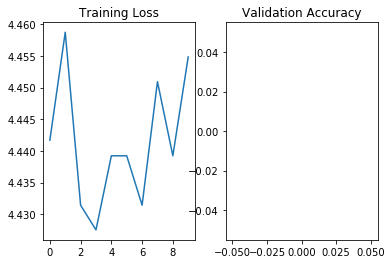

In [36]:
# 3-layer MLP
selected_team_shotlogs, team_labels, team_encodings, predications = baseline_team_classifier(1000)

In [37]:
result = hyp.cluster(team_encodings, ndims=2, n_clusters=3)
print(result)

[0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]


/Users/junyang/anaconda2/envs/p3/lib/python3.6/site-packages/hypertools/tools/cluster.py:73: UserWarning: The ndims argument is now deprecated. Ignoring dimensionality reduction step.
  warnings.warn('The ndims argument is now deprecated. Ignoring dimensionality reduction step.')


In [ ]:
team_segmentation_baseline = defaultdict(list)
for idx, label in enumerate(result):
    team_segmentation_baseline[label].append()

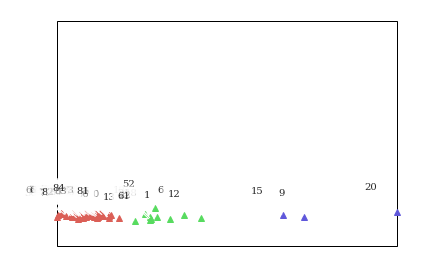

In [412]:
hyp.plot(team_encodings, '^', ndims=2, n_clusters = 3, labels = [selected_team_index[team] for team in selected_team_index])

after iteration 0: training loss: 4.448206901550293 ; validation accuracy: 0.0117647061124444
after iteration 100: training loss: 4.44702672958374 ; validation accuracy: 0.0117647061124444
after iteration 200: training loss: 4.447038650512695 ; validation accuracy: 0.0117647061124444
after iteration 300: training loss: 4.443132400512695 ; validation accuracy: 0.0117647061124444
after iteration 400: training loss: 4.439226150512695 ; validation accuracy: 0.0117647061124444
after iteration 500: training loss: 4.450944900512695 ; validation accuracy: 0.0117647061124444
after iteration 600: training loss: 4.439226150512695 ; validation accuracy: 0.0117647061124444
after iteration 700: training loss: 4.427507400512695 ; validation accuracy: 0.0117647061124444
after iteration 800: training loss: 4.447038650512695 ; validation accuracy: 0.0117647061124444
after iteration 900: training loss: 4.450944900512695 ; validation accuracy: 0.0117647061124444
(85, 4802) (85, 85)


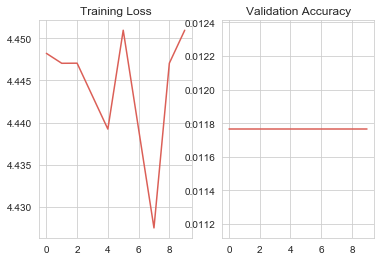

In [234]:
selected_team_shotlogs, team_labels, team_encodings, predications = baseline_team_classifier(1000)

In [239]:
for idx, label in enumerate(team_labels):
    print(idx_to_team(label), idx_to_team(predications[idx]))

Bears Cowboys
Eagles Cowboys
Tar Heels Cowboys
Cowboys Cowboys
Rams Cowboys
Spartans Cowboys
Tigers Cowboys
Gamecocks Cowboys
Golden Eagles Cowboys
Wildcats Cowboys
Huskies Cowboys
Aztecs Cowboys
Panthers Cowboys
Owls Cowboys
Lions Cowboys
Mustangs Cowboys
Mountaineers Cowboys
Aggies Cowboys
Cougars Cowboys
Broncos Cowboys
Bulldogs Cowboys
Colonials Cowboys
Trojans Cowboys
Knights Cowboys
Hawks Cowboys
Gators Cowboys
Wolfpack Cowboys
Blue Devils Cowboys
Nittany Lions Cowboys
Boilermakers Cowboys
Red Storm Cowboys
Billikens Cowboys
Gaels Cowboys
Orange Cowboys
Horned Frogs Cowboys
Longhorns Cowboys
Red Raiders Cowboys
Terrapins Cowboys
Wolverines Cowboys
Cornhuskers Cowboys
Sooners Cowboys
Rebels Cowboys
Cardinal Cowboys
Cavaliers Cowboys
Bluejays Cowboys
Bearcats Cowboys
Golden Gophers Cowboys
Volunteers Cowboys
Pirates Cowboys
Hoosiers Cowboys
Scarlet Knights Cowboys
Razorbacks Cowboys
Buffaloes Cowboys
Fighting Illini Cowboys
Bulls Cowboys
Hoyas Cowboys
Hawkeyes Cowboys
Lobos Cowboys

In [236]:
team_encodings[0]


array([   0.      ,    0.      ,    0.      ,  513.6143  ,    0.      ,
          0.      ,    0.      ,    0.      ,    0.      ,  739.1521  ,
          0.      ,    0.      ,    0.      ,    0.      ,  104.569534,
        781.73566 ,    0.      , 1360.8751  ,   75.309685,  637.34064 ,
          0.      ,    0.      ,    0.      ,    0.      ,  382.60785 ,
          0.      ,    0.      ,   43.918766,    0.      ,  576.8806  ,
          0.      ,    0.      ], dtype=float32)

In [237]:
team_encodings[40]

array([  0.      ,   0.      ,  42.131584, 350.5592  ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      , 517.29254 ,
         0.      ,   0.      ,   0.      ,   0.      , 104.95404 ,
       451.3039  ,   0.      , 966.1372  ,  26.603386, 500.8731  ,
         0.      ,   0.      ,   0.      ,   0.      , 272.64642 ,
         0.      ,   0.      ,  31.967443,   0.      , 447.79987 ,
         0.      ,   0.      ], dtype=float32)

In [392]:
hyp.plot(team_encodings, '^', ndims=2)

IndexError: list index out of range

In [221]:
import hypertools as hyp
hyp.plot(team_encodings, '.', ndims=2)

after iteration 0: training loss: 4.571860313415527 ; validation accuracy: 0.0
after iteration 100: training loss: 4.612572193145752 ; validation accuracy: 0.0117647061124444
after iteration 200: training loss: 4.550072193145752 ; validation accuracy: 0.0117647061124444
after iteration 300: training loss: 4.464134693145752 ; validation accuracy: 0.0117647061124444
after iteration 400: training loss: 4.534447193145752 ; validation accuracy: 0.0117647061124444
after iteration 500: training loss: 4.534447193145752 ; validation accuracy: 0.0117647061124444
after iteration 600: training loss: 4.503197193145752 ; validation accuracy: 0.0117647061124444
after iteration 700: training loss: 4.565697193145752 ; validation accuracy: 0.0117647061124444
after iteration 800: training loss: 4.495384693145752 ; validation accuracy: 0.0117647061124444
after iteration 900: training loss: 4.526634693145752 ; validation accuracy: 0.0117647061124444
Train Accuracy: 0.011764706
Test Accuracy: 0.011764706


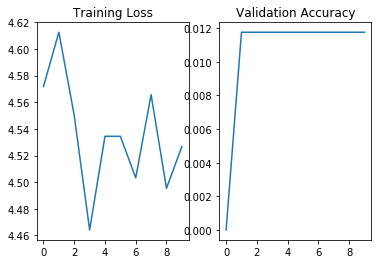

In [166]:
baseline_team_classifier(1000)

### RNN model

#### Data Preparation

In [38]:
RNN_data_matrix = []
for team in ncaa_shotlogs_team_selected:
    for item in ncaa_shotlogs_team_selected[team]:
        logs = []
        for log in item:
            logs.append([log[0], log[1], log[2]])
        RNN_data_matrix.append((logs,team_to_one_hot_vector(team)))
    

In [39]:
print(len(RNN_data_matrix))
print(RNN_data_matrix[10][0])
print(idx_to_team(RNN_data_matrix[12][1]))
print(np.array(RNN_data_matrix[13][0]).reshape([1,-1,3]).shape)

15464
[[44, 94, 577], [80, 284, 93], [117, 81, 282], [125, 87, 306], [201, 111, 307], [209, 54, 33], [245, 125, 354], [278, 83, 33], [335, 91, 35], [385, 314, 131], [419, 349, 299], [429, 108, 295], [454, 217, 217], [463, 69, 286], [486, 135, 314], [529, 221, 211], [569, 329, 84], [605, 62, 114], [642, 384, 223], [668, 78, 313], [721, 355, 319], [752, 86, 314], [830, 315, 105], [874, 77, 278], [904, 112, 29], [967, 368, 409], [994, 283, 313], [1031, 379, 398], [1079, 297, 108], [1146, 294, 112], [1186, 328, 417], [1199, 432, 153], [1214, 305, 452], [1247, 153, 187], [1288, 105, 266], [1390, 253, 312], [1415, 89, 276], [1452, 113, 233], [1484, 110, 241], [1505, 89, 273], [1569, 112, 23], [1654, 357, 315], [1710, 60, 310], [1756, 201, 279], [1848, 346, 369], [1881, 291, 476], [1899, 79, 280], [1935, 77, 274], [2053, 335, 56], [2091, 216, 181], [2135, 390, 88], [2157, 60, 569], [2182, 346, 273], [2223, 218, 533], [2232, 178, 286], [2298, 110, 19], [2317, 343, 274], [2323, 347, 406], [2334

#### RNN model setup

In [40]:
tf.reset_default_graph()
# sizes
n_steps = None
n_inputs = 3
n_neurons = 128
encoding_dim = 32
output_size = 85
# Build RNN
X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
Y= tf.placeholder(tf.float32, [None, 85])
# basic_cell = tf.contrib.rnn.BasicRNNCell(n_neurons,activation=tf.nn.tanh)
basic_cell = tf.contrib.rnn.LSTMCell(n_neurons,activation=tf.nn.tanh)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
# last_cell_output=outputs[:,-1,:]
encodings =tf.layers.dense(outputs, encoding_dim, name="encoding", activation=tf.nn.tanh,kernel_initializer=tf.contrib.layers.xavier_initializer())
Y_bar = tf.layers.dense(encodings, output_size, name="output", activation=tf.nn.softmax,kernel_initializer=tf.contrib.layers.xavier_initializer())

# Loss and metrics
rnn_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y_bar, labels=Y))
# Calculate the correct predictions
correct_prediction = tf.equal(tf.argmax(Y_bar), tf.argmax(Y))
# Calculate accuracy on the test set
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# training
adam_optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(rnn_loss)

In [355]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(1):
    random.shuffle(RNN_data_matrix)
    for idx, record in enumerate(RNN_data_matrix):
        data = np.array(record[0]).reshape([1,-1,3])
        label = np.array(record[1]).reshape([1, 85])
        _, l = sess.run([adam_optimizer, rnn_loss], feed_dict={X: data, Y: label})
        if idx % 1000 == 0:
            print("epoch:{}, batch:{}, loss: {}".format(epoch, idx, l))


epoch:0, batch:0, loss: 4.447434425354004
epoch:0, batch:1000, loss: 4.427624702453613
epoch:0, batch:2000, loss: 4.456979274749756
epoch:0, batch:3000, loss: 4.456169605255127
epoch:0, batch:4000, loss: 4.4569525718688965
epoch:0, batch:5000, loss: 4.458457946777344
epoch:0, batch:6000, loss: 4.456943988800049
epoch:0, batch:7000, loss: 4.460599422454834
epoch:0, batch:8000, loss: 4.447883129119873
epoch:0, batch:9000, loss: 4.456704139709473
epoch:0, batch:10000, loss: 4.457958221435547
epoch:0, batch:11000, loss: 4.457030773162842
epoch:0, batch:12000, loss: 4.459680080413818
epoch:0, batch:13000, loss: 4.460052967071533
epoch:0, batch:14000, loss: 4.4566850662231445
epoch:0, batch:15000, loss: 4.386163234710693


In [41]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for epoch in range(1):
    random.shuffle(RNN_data_matrix)
    for idx, record in enumerate(RNN_data_matrix):
        data = np.array(record[0]).reshape([1,-1,3])
        label = np.array(record[1]).reshape([1, 85])
        _, l = sess.run([adam_optimizer, rnn_loss], feed_dict={X: data, Y: label})
        if idx % 1000 == 0:
            print("epoch:{}, batch:{}, loss: {}".format(epoch, idx, l))

epoch:0, batch:0, loss: 4.444322109222412
epoch:0, batch:1000, loss: 4.443289279937744
epoch:0, batch:2000, loss: 4.45729923248291
epoch:0, batch:3000, loss: 4.458645820617676
epoch:0, batch:4000, loss: 4.459331512451172
epoch:0, batch:5000, loss: 4.457846641540527
epoch:0, batch:6000, loss: 4.15470552444458
epoch:0, batch:7000, loss: 4.456711769104004
epoch:0, batch:8000, loss: 4.456624984741211
epoch:0, batch:9000, loss: 4.457615375518799
epoch:0, batch:10000, loss: 4.457310676574707
epoch:0, batch:11000, loss: 4.457842826843262
epoch:0, batch:12000, loss: 4.458157062530518
epoch:0, batch:13000, loss: 4.457540512084961
epoch:0, batch:14000, loss: 4.4565582275390625
epoch:0, batch:15000, loss: 4.457018852233887


In [60]:
team_encodings_rnn = []
predictions = []
for team in selected_team_index:
    data = np.array(ncaa_shotlogs_team_selected[team][20]).reshape([1,-1,3])
#     label = team_to_one_hot_vector(team).reshape([1,85]) 

    team_encoding, prediction = sess.run([encodings, Y_bar], feed_dict={X: data})
    team_encodings_rnn.append(team_encoding)
    predictions.append(prediction)

In [61]:
rnn_encodings = []
for i in range(len(team_encodings_rnn)):
    rnn_encodings.append(np.array(team_encodings_rnn[i].max(0).max(0)).reshape(1,32))

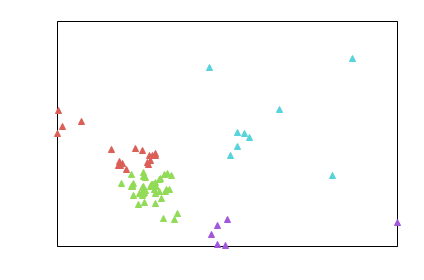

In [62]:
hyp.plot(rnn_encodings, '^', ndims=2, n_clusters = 4)

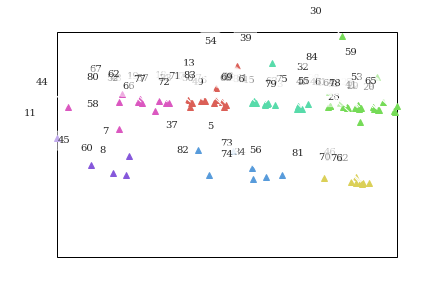

In [410]:
hyp.plot(rnn_encodings, '^', ndims=2, n_clusters = 7, labels = [selected_team_index[team] for team in selected_team_index])

In [377]:
team_encodings_rnn[0].mean(0).max(0)

array([ 0.99563164,  0.98855937, -0.6582836 ,  0.99737495,  0.99049485,
       -0.8661912 ,  0.93143684, -0.9913498 ,  0.9841661 ,  0.829463  ,
        0.98959637, -0.95378244,  0.99906456,  0.50231427, -0.835229  ,
       -0.8226433 ,  0.9959816 , -0.96841615, -0.5516308 ,  0.46670327,
        0.5854311 , -0.9549556 , -0.8771957 ,  0.27053759,  0.955697  ,
        0.5269124 , -0.8544096 ,  0.7222135 , -0.9725213 ,  0.8941763 ,
        0.75635123, -0.9514828 ], dtype=float32)

In [378]:
team_encodings_rnn[10].mean(0).max(0)

array([ 0.99567527,  0.98855835, -0.6583306 ,  0.9974    ,  0.9912788 ,
       -0.83477414,  0.9314365 , -0.99227   ,  0.9841661 ,  0.83042896,
        0.98959416, -0.9480081 ,  0.9990647 ,  0.52574044, -0.8207353 ,
       -0.8012012 ,  0.99603724, -0.9685299 , -0.5516815 ,  0.46669117,
        0.58541995, -0.95614034, -0.87778795,  0.33786803,  0.9564206 ,
        0.60597163, -0.8641399 ,  0.7221923 , -0.9713743 ,  0.89265984,
        0.75635105, -0.9431811 ], dtype=float32)

In [373]:
team_encodings_rnn[50].mean(0).mean(0)

array([ 0.98903054,  0.9837473 , -0.7791832 ,  0.99577785,  0.97858995,
       -0.972447  ,  0.9143532 , -0.9976824 ,  0.9681935 ,  0.7481419 ,
        0.9738568 , -0.98599154,  0.9984612 ,  0.24312913, -0.8670721 ,
       -0.96030754,  0.9865632 , -0.99134105, -0.7110201 ,  0.34793547,
        0.5322645 , -0.9835538 , -0.92384213,  0.24148975,  0.93609846,
        0.36913908, -0.9109325 ,  0.541651  , -0.9932005 ,  0.82530284,
        0.7055363 , -0.9867476 ], dtype=float32)

In [374]:
predictions[6]

array([[[1.2891741e-05, 5.1154316e-06, 1.6399468e-06, ...,
         1.0508960e-06, 4.0267810e-07, 3.8662444e-07],
        [7.9936190e-06, 3.0945523e-06, 1.0016176e-06, ...,
         5.9880887e-07, 2.3395636e-07, 2.1753912e-07],
        [1.0402674e-05, 3.3732365e-06, 1.2199613e-06, ...,
         7.8136509e-07, 3.0418249e-07, 2.5563779e-07],
        ...,
        [7.2678376e-06, 3.0317058e-06, 7.5462384e-07, ...,
         5.2625700e-07, 1.8895865e-07, 1.6197640e-07],
        [7.2678376e-06, 3.0317058e-06, 7.5462384e-07, ...,
         5.2625700e-07, 1.8895865e-07, 1.6197640e-07],
        [7.2678263e-06, 3.0316980e-06, 7.5460332e-07, ...,
         5.2624915e-07, 1.8895493e-07, 1.6197322e-07]]], dtype=float32)

In [340]:
predictions[7]

array([[1.3512688e-05, 7.1820123e-06, 1.1339021e-06, 4.2603583e-06,
        1.7175926e-05, 1.3820659e-05, 2.6895922e-01, 3.8200588e-07,
        3.1227526e-06, 4.8633417e-01, 8.2126629e-05, 2.1446549e-06,
        4.4547455e-06, 6.1761460e-07, 4.0719419e-07, 4.3141375e-07,
        4.2231724e-07, 1.6220786e-06, 2.4532867e-04, 1.3722150e-06,
        2.4425900e-01, 6.7292234e-08, 4.2236476e-07, 8.9440033e-07,
        1.3441804e-07, 9.9077033e-07, 9.1743027e-07, 4.6557884e-07,
        6.2061012e-08, 1.4231325e-06, 1.4037853e-06, 1.3487055e-07,
        3.7849486e-07, 1.5453904e-07, 2.8564298e-07, 4.2319778e-07,
        5.8000825e-07, 5.2165632e-07, 4.8750940e-07, 3.0946637e-07,
        1.2825190e-06, 3.3464053e-06, 7.8592547e-07, 4.4990605e-07,
        3.1240336e-06, 7.8049686e-07, 1.3501108e-07, 1.1114502e-07,
        3.3792194e-06, 7.2347632e-07, 4.1405724e-07, 1.0632070e-06,
        9.9705278e-07, 6.0437721e-08, 1.9046806e-07, 2.2642986e-07,
        1.5938375e-06, 4.6866486e-08, 6.9520020e

# Synthetic Play Generation

In [16]:
# hyperparameters
num_layers = 2 # num of LSTM layers
hidden_units = 64 #Hidden size of the LSTM
max_grad = 1 #Clip the gradients during training
sequence_length = 50
learning_rate = .0005
batch_size = 8 # we only have 8 games
num_features = 2 # x,y coordinates

In [17]:
# input data
shotlog_duke = []
for game in new_duke_shotlogs:
    shotlog_duke.append(np.array(new_duke_shotlogs[game][:sequence_length]).reshape(sequence_length,3))
input_shotlogs = np.array(shotlog_duke).reshape(8,sequence_length,3)
input_shotlogs = input_shotlogs[:,:,1:]
print(input_shotlogs.shape)
print(input_shotlogs[:,0])

(8, 50, 2)
[[14 44]
 [11  8]
 [ 3 37]
 [30  8]
 [36 47]
 [ 8  2]
 [27 27]
 [25 15]]


In [186]:
print(input_shotlogs[0,0].reshape(1,1,2))

[[[14 44]]]


In [18]:
target_shotlogs = input_shotlogs.transpose([1,0,2])
print(target_shotlogs.shape)

(50, 8, 2)


# RNN Model

In [171]:
tf.reset_default_graph()

data = tf.placeholder(tf.float32, [None,sequence_length, 2])
sample_data = tf.placeholder(tf.float32, [1, 2])
W1 = tf.get_variable("W1", [hidden_units, hidden_units*2],initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1", [hidden_units*2,], initializer=tf.zeros_initializer())
W2 = tf.get_variable("W2", [hidden_units*2, 2],initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2", [2,], initializer=tf.zeros_initializer())

dropout = tf.placeholder(tf.float32)

loss = 0.0

cells = []
for _ in range(num_layers):
  cell = tf.contrib.rnn.LSTMCell(hidden_units)  # Or LSTMCell(num_units)
  cell = tf.contrib.rnn.DropoutWrapper(
      cell, output_keep_prob=1.0 - dropout)
  cells.append(cell)
cell = tf.contrib.rnn.MultiRNNCell(cells)
state = cell.zero_state(hidden_units, tf.float32)

# output, state = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)

for i in range(sequence_length-1):
    #print(tf.shape(data[:,i]))
    output,state = cell(data[:,i,:], state)
    output = tf.add(tf.matmul(output, W1), b1)
    output = tf.nn.relu(output)
    output_loc = tf.add(tf.matmul(output, W2), b2)
    #output_loc = tf.layers.dense(output,hidden_units, activation=tf.nn.relu)
    #output_loc = tf.layers.dense(output_loc,2)
    loss += tf.reduce_mean(tf.losses.mean_squared_error(labels=data[:,i+1,:], predictions=output_loc))

# gradients clippling
optimizer = tf.train.AdamOptimizer(learning_rate)
grads = optimizer.compute_gradients(loss)
capped_grads = [(tf.clip_by_value(grad, -max_grad, max_grad), var) for grad, var in grads]
train_step = optimizer.apply_gradients(capped_grads)

#generative model
#initial_x = tf.placeholder(tf.float32, [None, 2])
# generative_initial_state = cell.zero_state(hidden_units, tf.float32)

# new_x = sample_data
# new_state = generative_initial_state

# generative_sequences = []
# for i in range(sequence_length):
#     print(i, tf.shape(new_x))
#     new_x, new_state = cell(new_x, new_state)
#     new_x = tf.add(tf.matmul(new_x, W1),b1)
#     new_x = tf.nn.relu(new_x)
#     new_x = tf.add(tf.matmul(new_x, W2),b2)
#     print(tf.shape(new_x))
#     generative_sequences.append(new_x)



In [122]:
initialize_all = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initialize_all)

for epoch in range(50000):
    _,l = sess.run([train_step,loss], feed_dict={data:input_shotlogs, dropout:0.2})
    if epoch % 1000 == 0:
        print('epoch:{}, loss:{}'.format(epoch, l))

epoch:0, loss:45267.125
epoch:1000, loss:6922.4150390625
epoch:2000, loss:3083.72705078125
epoch:3000, loss:868.6622924804688
epoch:4000, loss:599.1519775390625
epoch:5000, loss:452.5675354003906
epoch:6000, loss:352.82611083984375
epoch:7000, loss:303.3631286621094
epoch:8000, loss:277.6634826660156
epoch:9000, loss:231.87364196777344
epoch:10000, loss:201.63623046875
epoch:11000, loss:178.29978942871094
epoch:12000, loss:152.9326629638672
epoch:13000, loss:125.4869155883789
epoch:14000, loss:112.28866577148438
epoch:15000, loss:100.67709350585938
epoch:16000, loss:96.2220230102539
epoch:17000, loss:80.17724609375
epoch:18000, loss:75.40766906738281
epoch:19000, loss:65.08458709716797
epoch:20000, loss:64.17732238769531
epoch:21000, loss:55.20379638671875
epoch:22000, loss:51.65401840209961
epoch:23000, loss:53.921329498291016
epoch:24000, loss:42.17322540283203
epoch:25000, loss:44.463321685791016
epoch:26000, loss:40.364219665527344
epoch:27000, loss:31.652250289916992
epoch:28000, 

# RNN Generative Model using 

In [166]:
import sys
!{sys.executable} -m pip install keras

    100% |████████████████████████████████| 317kB 1.1MB/s 
    100% |████████████████████████████████| 6.1MB 120kB/s 
    100% |████████████████████████████████| 276kB 1.6MB/s 
    100% |████████████████████████████████| 51kB 6.0MB/s 
  Running setup.py bdist_wheel for pyyaml ... - \ | done
  Stored in directory: /Users/junyang/Library/Caches/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
Successfully built pyyaml
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [19]:
reshapor = Reshape((1,2))
LSTM_cell = LSTM(hidden_units, return_state=True)
dense_layer = Dense(hidden_units*2, activation='relu')
dense_output = Dense(2)

In [20]:
def model(sequence_length, hidden_units, num_features):
    X = Input(shape=(sequence_length, num_features))
    
    a0 = Input(shape= (hidden_units,))
    c0 = Input(shape= (hidden_units,))
    
    a = a0
    c = c0
    
    outputs = []
    for t in range(sequence_length):
        x = Lambda(lambda x: X[:,t,:])(X)
        x = reshapor(x)
        a,_,c = LSTM_cell(x, initial_state=[a,c])
        out = dense_layer(a)
        out = dense_output(out)
        
        outputs.append(out)
    
    model = Model(inputs=[X,a0,c0], outputs=outputs)
    
    return model

In [21]:
play_model = model(sequence_length, hidden_units, num_features)
adam_optimizer = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
play_model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

In [22]:
a0 = np.zeros((8, hidden_units))
c0 = np.zeros((8, hidden_units))
play_model.fit([input_shotlogs, a0, c0], list(target_shotlogs), epochs=500)

Epoch 1/500
8/8 [==============================] - 43s 5s/step - loss: 24135.8516 - dense_4_loss: 417.3273
Epoch 2/500
8/8 [==============================] - 0s 8ms/step - loss: 22794.7559 - dense_4_loss: 392.1561
Epoch 3/500
8/8 [==============================] - 0s 8ms/step - loss: 21404.8398 - dense_4_loss: 366.7976
Epoch 4/500
8/8 [==============================] - 0s 8ms/step - loss: 20015.2676 - dense_4_loss: 342.2091
Epoch 5/500
8/8 [==============================] - 0s 8ms/step - loss: 18508.1387 - dense_4_loss: 314.8249
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 16822.2305 - dense_4_loss: 284.8847
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 14952.8643 - dense_4_loss: 253.2656
Epoch 8/500
8/8 [==============================] - 0s 8ms/step - loss: 12943.6680 - dense_4_loss: 221.0917
Epoch 9/500
8/8 [==============================] - 0s 8ms/step - loss: 10901.3486 - dense_4_loss: 189.9483
Epoch 10/500
8/8 [===================

In [30]:
def generation_model(LSTM_cell, dense_layer, dense_output, num_features=2, hidden_units=64, sequence_length=50):
    x0 = Input(shape=(1, num_features))
    
    a0 = Input(shape=(hidden_units,))
    c0 = Input(shape=(hidden_units,))
    
    a = a0
    c = c0
    x = x0
    
    outputs = []
    
    for t in range(sequence_length):
        a,_,c = LSTM_cell(x, initial_state=[a,c])
        
        out = dense_layer(a)
        out = dense_output(out)
        
        outputs.append(out)
        
    model = Model(inputs = [x0,a0,c0], outputs = outputs)
    
    return model

In [31]:
play_generation = generation_model(LSTM_cell, dense_layer, dense_output)

In [32]:
x_initializer = input_shotlogs[0,1,:].reshape(1,1,2)
a_initializer = np.zeros((1, hidden_units))
c_initializer = np.zeros((1, hidden_units))

In [33]:
play_series = play_generation.predict([x_initializer, a_initializer,c_initializer])

In [36]:
print(len(play_series))
for item in play_series:
    for loc in item:
        print(loc[0], loc[1])
print(len(input_shotlogs[0,:50,:]))
for item in input_shotlogs[0,:50,:]:
    print(item[0], item[1])

50
4.038827 29.43664
3.07277 24.85634
2.5611444 21.029875
2.8858504 21.99013
2.808167 22.06421
2.6558635 21.793463
2.6467242 21.752207
2.6646378 21.781168
2.6784487 21.802904
2.689477 21.817507
2.6987665 21.82796
2.7068658 21.835796
2.7141562 21.84199
2.7208922 21.847136
2.7272463 21.8516
2.7333307 21.855616
2.739223 21.859335
2.7449746 21.862846
2.750613 21.866209
2.7561643 21.869463
2.7616363 21.872633
2.7670372 21.875734
2.7723718 21.878773
2.7776403 21.881758
2.7828465 21.884695
2.7879832 21.887583
2.7930536 21.890417
2.7980561 21.893204
2.8029866 21.895945
2.8078437 21.898634
2.812625 21.901274
2.8173287 21.90386
2.8219543 21.9064
2.826498 21.908888
2.8309596 21.911318
2.835337 21.9137
2.8396277 21.916025
2.8438334 21.918299
2.8479528 21.920519
2.8519793 21.922684
2.8559208 21.924797
2.8597717 21.926855
2.863532 21.92886
2.8672032 21.930813
2.870783 21.932709
2.8742728 21.934553
2.877675 21.93635
2.8809862 21.93809
2.8842082 21.939781
2.887342 21.941422
50
14 44
3 22
4 26
5 24
4 4

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x= []
y= []
for item in input_shotlogs[0,:,:]:
    x.append(item[0])
    y.append(item[1])
plt.scatter(x,y)
plt.title("real play")

x = []
y = []
plt.subplot(1,2,2)
for item in play_series:
    for loc in item:
        x.append(loc[0])
        y.append(loc[1])
plt.scatter(x,y)
plt.title("synthetic play generation")